# To do

- use additional datasets
- dependence on ordering/all questions?

# Setup

In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

In [2]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/ptsd/PTSD_cognet_test_processed.csv")
Tr.fit(modelpath="tmp_Qnet.joblib")

Tr_pos = truthnet()
feat_pos, samp_pos = Tr_pos.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_pos_only.csv"
)
Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

Tr_neg = truthnet()
feat_neg, samp_neg = Tr_neg.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_neg_only.csv"
)
Tr_neg.fit(modelpath="tmp_Qnet_neg.joblib")

In [2]:
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _sample_with_dissonance(
    sample_model, length, diss_models, diss_fcn=_diss_linear, order=None
):
    if order is None:
        order = range(length)

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    feature_vecs = list()

    for i in order:
        prob_dict = sample_model.predict_distribution(sample, i)
        sample[i] = sample_from_dict(prob_dict)
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _nsamples_with_dissonance(
    n_samples, sample_model, length, diss_models, diss_fcn=_diss_linear, order=None
):
    samples = list()
    dissonances = list()

    for i in tqdm(range(n_samples)):
        samp, diss = _sample_with_dissonance(
            sample_model, length, diss_models, diss_fcn, order
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


# generate samples under the given models and compute dissonances under specified diss_models
def _sampling_scenario(
    n_qsamples,
    qsample_model,
    n_m2_samples,
    m2_model,
    diss_models,
    length,
    diss_fcn=_diss_linear,
    order=None,
):
    samples = {}
    dissonances = {}

    if order == "entropy":
        Ds = qsample_model.predict_distributions(np.full(length, ""))
        entrpy = list()
        for i in range(len(Ds)):
            entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
        order = pd.Series(entrpy).sort_values().index

    samples["qsampled"], dissonances["qsampled"] = _nsamples_with_dissonance(
        n_qsamples, qsample_model, length, diss_models, diss_fcn, order
    )

    samples["m2"], dissonances["m2"] = _nsamples_with_dissonance(
        n_m2_samples, m2_model, length, diss_models, diss_fcn, order
    )

    return samples, dissonances


def _diss_dataset(dissonances, questions_asked):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in ["qsampled", "m2"]
        ]
    )
    return diss_dataset

Here we generate base qsamples from the full model, m2 samples as qsamples from the positive only model, and compute dissonances under negative and positive models.

In [ ]:
full_model = Tr.cognet_obj.qnet
pos_model = Tr_pos.cognet_obj.qnet
neg_model = Tr_neg.cognet_obj.qnet

diss_models = [full_model, neg_model, pos_model]
n_qsamples = 10
n_m2_samples = 10

s, d = _sampling_scenario(
    n_qsamples, full_model, n_m2_samples, pos_model, diss_models, 211
)

In [3]:
def _save_sampling_scenarios(
    n, n_qsamples, n_m2_samples, length, diss_fcn=_diss_linear, order=None
):
    for i in tqdm(range(n)):
        Tr = truthnet()
        features, samples = Tr.load_data(
            datapath="data/ptsd/PTSD_cognet_test_processed.csv"
        )
        Tr.fit(modelpath="tmp_Qnet.joblib")

        Tr_pos = truthnet()
        feat_pos, samp_pos = Tr_pos.load_data(
            datapath="data/ptsd/PTSD_cognet_test_processed_pos_only.csv"
        )
        Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

        Tr_neg = truthnet()
        feat_neg, samp_neg = Tr_neg.load_data(
            datapath="data/ptsd/PTSD_cognet_test_processed_neg_only.csv"
        )
        Tr_neg.fit(modelpath="tmp_Qnet_neg.joblib")

        full_model = Tr.cognet_obj.qnet
        pos_model = Tr_pos.cognet_obj.qnet
        neg_model = Tr_neg.cognet_obj.qnet

        diss_models = [full_model, neg_model, pos_model]

        s, d = _sampling_scenario(
            n_qsamples,
            full_model,
            n_m2_samples,
            pos_model,
            diss_models,
            length,
            diss_fcn,
            order,
        )

        pd.to_pickle(s, "samps_" + str(i) + ".pkl")
        pd.to_pickle(d, "disson_" + str(i) + ".pkl")

In [ ]:
_save_sampling_scenarios(10, 100, 100, 211, order="entropy")

In [78]:
questions_asked = 11

data = _diss_dataset(diss[0], questions_asked)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

In [66]:
pd.DataFrame(
    np.nan_to_num(
        X_train.iloc[:, questions_asked : 2 * questions_asked].to_numpy()
        / X_train.iloc[:, 2 * questions_asked :].to_numpy(),
        nan=1,
    )
)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000e+00,1.000000,1.025803,1.000000,1.000000,1.059746,12.662577,1.000000e+00,1.000000,1.000000,0.000000
1,1.797693e+308,1.377419,0.949875,2.354927,1.072727,0.904901,1.000000,1.797693e+308,1.000000,0.991517,0.000000
2,7.129630e-02,1.000000,1.000000,1.364160,1.000000,1.000000,1.000000,2.162940e+00,1.000000,1.000000,1.000000
3,7.129630e-02,1.126868,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000
4,1.000000e+00,1.126868,1.000000,1.000000,1.094679,1.000000,12.662577,1.000000e+00,1.000000,0.914591,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
129,7.129630e-02,1.000000,1.025803,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000
130,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000
131,1.186610e+00,1.000000,1.000000,1.000000,1.000000,1.059746,1.000000,2.085940e+00,1.000000,1.000000,0.000000
132,1.000000e+00,1.047150,0.949875,1.263828,1.000000,1.000000,2.866258,2.162940e+00,1.000000,0.889147,0.954545


# Results

In [5]:
results = {
    "neg_pos_diss": {},
    "all_diss": {},
    "pos_diss_only": {},
    "diss_ratio": {},
}

In [4]:
diss = [pd.read_pickle(d) for d in glob.glob("disson/disson*.pkl")]

In [ ]:
classifier = RandomForestClassifier(n_jobs=-1)

param = {
    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
    "max_depth": trial.suggest_int("max_depth", 5, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
}

In [ ]:
auc_dfs = list()
plot = False
retrains = 3
question_iter = range(1, 212, 5)
res = "all_diss"


classifier = lgb.LGBMClassifier(verbosity=-100)

# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                param = {
                    "objective": "binary",
                    "metric": "auc",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                    "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                    "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                    "feature_fraction": trial.suggest_float(
                        "feature_fraction", 0.4, 1.0
                    ),
                    "bagging_fraction": trial.suggest_float(
                        "bagging_fraction", 0.4, 1.0
                    ),
                    "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            "qsampled": 0,
                            "m2": 1,
                        }
                    ),
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            "qsampled": 0,
                            "m2": 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=100)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        "qsampled": 0,
                        "m2": 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        "qsampled": 0,
                        "m2": 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        "qsampled": 0,
                        "m2": 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df)
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        auc_dfs.append(auc_df)
        auc_df.to_csv(
            "data/classification/lgbm_auc_res/auc_df_lgb_"
            + str(datetime.now())
            + ".csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        "data/classification/lgbm_auc_res/auc_dfs_lgb_" + str(datetime.now()) + ".csv",
        index=False,
    )

results[res][str(classifier) + "_" + str(classifier.get_params())] = (
    pd.concat(auc_dfs).groupby(level=0).mean()
)

results

In [ ]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    data = _diss_dataset(d, questions_asked)
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop("y", axis="columns"), data["y"], test_size=0.33
    )

    # X_train = X_train.mean(axis=1)
    # X_test = X_test.mean(axis=1)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    classifier = lgb.LGBMClassifier(**param)
    classifier.fit(
        X_train.to_numpy(),
        y_train.replace(
            {
                "qsampled": 0,
                "m2": 1,
            }
        ),
    )

    r = RocCurveDisplay.from_estimator(
        classifier,
        X_test.to_numpy(),
        y_test.replace(
            {
                "qsampled": 0,
                "m2": 1,
            }
        ),
        pos_label=1,
        ax=ax,
        name=questions_asked,
    )

    return r.roc_auc


study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
)
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [86]:
study.best_trial.params

{'lambda_l1': 0.0006866744186441409,
 'lambda_l2': 7.742670451140207e-07,
 'num_leaves': 79,
 'feature_fraction': 0.6580897004942353,
 'bagging_fraction': 0.6533074079902044,
 'bagging_freq': 1,
 'min_child_samples': 35}

In [87]:
all_results

{'neg_pos_diss': {'randomforestclassifierbootstrap-true-ccp_alpha-00-class_weight-none-criterion-gini-max_depth-none-max_features-sqrt-max_leaf_nodes-none-max_samples-none-min_impurity_decrease-00-min_samples_leaf-1-min_samples_split-2-min_weight_fraction_leaf-00-n_estimators-100-n_jobs-none-oob_score-false-random_state-none-verbose-0-warm_start-false':    questions asked       auc     z_auc  z_auc_lb  z_auc_ub
  0              2.0  0.533381  0.571019  0.488744  0.653476
  1              5.0  0.566273  0.631054  0.551521  0.710680
  2              8.0  0.647786  0.704254  0.634436  0.774183
  3             11.0  0.692142  0.735497  0.667959  0.803105
  4             14.0  0.736816  0.773475  0.709369  0.837625
  5             17.0  0.767722  0.797364  0.736068  0.858698
  6             20.0  0.802735  0.831863  0.780556  0.883202
  7             23.0  0.809363  0.834356  0.782312  0.886428,
  'xgbrfclassifierbase_scorenone-boosternone-callbacksnone-colsample_bylevelnone-colsample_bytre

# Old implementation

We order questions based on increasing entropy: questions with the least entropy have the most potential for dissonant/surprising responses. (This could also be done dynamically: after each response, recompute the distributions and choose the remaining one with minimal entropy.)

In [3]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/ptsd/PTSD_cognet_test_processed.csv")
Tr.fit(modelpath="tmp_Qnet.joblib")

Tr_pos = truthnet()
feat_pos, samp_pos = Tr_pos.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_pos_only.csv"
)
Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

Tr_neg = truthnet()
feat_neg, samp_neg = Tr_neg.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_neg_only.csv"
)
Tr_neg.fit(modelpath="tmp_Qnet_neg.joblib")

In [4]:
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _compare_dissonance(
    samples, qnet, qnet_pos, order=None, diss_fcn=_diss_linear, plot=True
):
    samples_df = pd.DataFrame(samples)
    sample_values = pd.Series({col: samples_df[col].unique() for col in samples_df})

    if order is None:
        order = range(len(samples[0]))

    mean_diss_random = list()
    mean_diss_qsampled = list()
    mean_diss_qsampled_pos = list()
    mean_diss_m2 = list()
    mean_diss_m2_pos = list()
    mean_diss_m3 = list()

    new_samp_r = np.full_like(samples[0], fill_value="")
    new_samp_q = np.full_like(samples[0], fill_value="")
    new_samp_q_pos = np.full_like(samples[0], fill_value="")
    new_samp_m2 = np.full_like(samples[0], fill_value="")
    new_samp_m2_pos = np.full_like(samples[0], fill_value="")
    new_samp_m3 = np.full_like(samples[0], fill_value="")

    for i in order:
        # generate answers randomly
        new_samp_r[i] = random.choice(sample_values[i])
        mean_diss_random.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_r, qnet)))
        )

        # baseline/comparison answers (generated from full model)
        prob_dict = qnet.predict_distribution(new_samp_q, i)
        new_samp_q[i] = sample_from_dict(prob_dict)
        mean_diss_qsampled.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet)))
        )
        mean_diss_qsampled_pos.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet_pos)))
        )

        # generate answers from positive qnet distributions
        prob_dict_pos = qnet_pos.predict_distribution(new_samp_m2, i)
        new_samp_m2[i] = sample_from_dict(prob_dict_pos)
        mean_diss_m2.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m2, qnet))))
        mean_diss_m2_pos.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m2, qnet_pos)))
        )

        new_samp_m3[i] = random.choices(
            sample_values[i], weights=sample_values[i].astype(int) ** 2
        )[0]
        mean_diss_m3.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m3, qnet))))

    mean_diss_qsampled = np.array(mean_diss_qsampled)
    mean_diss_qsampled_pos = np.array(mean_diss_qsampled_pos)
    mean_diss_random = np.array(mean_diss_random)
    mean_diss_m2 = np.array(mean_diss_m2)
    mean_diss_m2_pos = np.array(mean_diss_m2_pos)
    mean_diss_m3 = np.array(mean_diss_m3)

    mean_df = pd.DataFrame(
        {
            "random_diss": mean_diss_random,
            "qsampled_diss": mean_diss_qsampled,
            "qsampled_diss_pos": mean_diss_qsampled_pos,
            "m2_diss": mean_diss_m2,
            "m2_diss_pos": mean_diss_m2_pos,
            "m3_diss": mean_diss_m3,
        }
    )

    if plot is True:
        sns.relplot(
            data=pd.melt(
                mean_df.reset_index(),
                id_vars="index",
            ),
            x="index",
            y="value",
            hue="variable",
        )

    return pd.concat(
        [
            mean_df,
            pd.DataFrame(
                {
                    "random_resp": new_samp_r,
                    "qsampled_resp": new_samp_q,
                    "m2_resp": new_samp_m2,
                    "m3_resp": new_samp_m3,
                }
            ),
        ],
        axis=1,
    )

In [5]:
Ds = Tr.cognet_obj.qnet.predict_distributions(np.full_like(samples[0], fill_value=""))
entrpy = list()
for i in range(len(Ds)):
    entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))

entropy_order = pd.Series(entrpy).sort_values().index

## Linear dissonance

### Entropy ordering

In [6]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        order=entropy_order,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

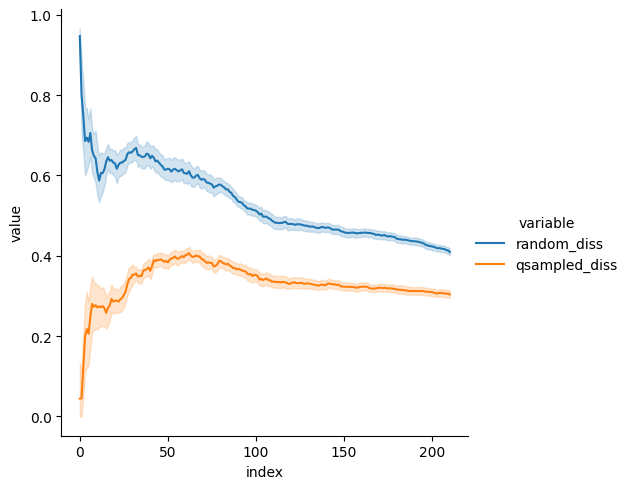

In [7]:
sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["random_diss", "qsampled_diss"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

### Random ordering

In [8]:
random_order = list(range(len(samples[0])))
random.shuffle(random_order)

mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        order=random_order,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

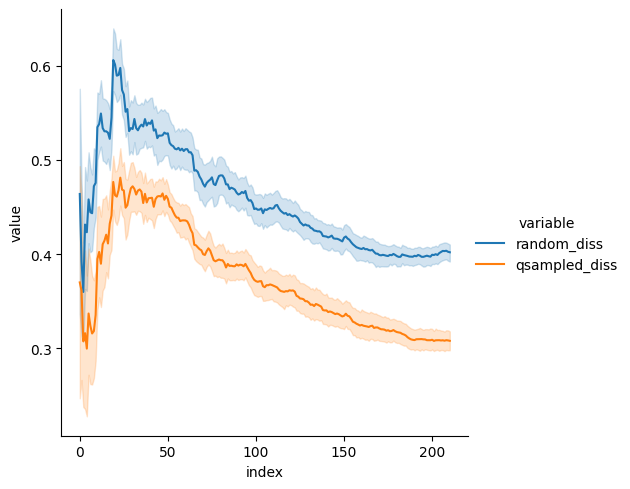

In [9]:
sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["random_diss", "qsampled_diss"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Log. dissonance

In [10]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        order=entropy_order,
        diss_fcn=_diss_log,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

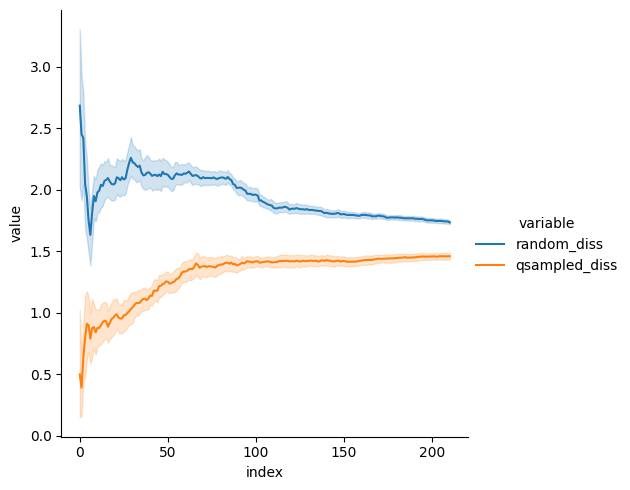

In [11]:
sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["random_diss", "qsampled_diss"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Adversarial responses

In [7]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        diss_fcn=_diss_log,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

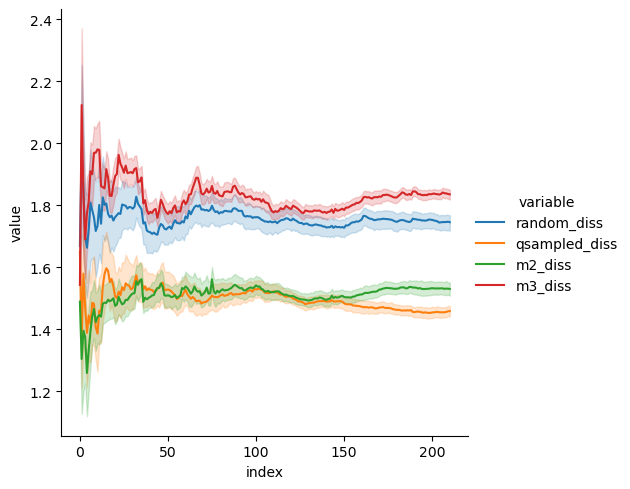

In [8]:
g = sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[
            ["random_diss", "qsampled_diss", "m2_diss", "m3_diss"]
        ].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

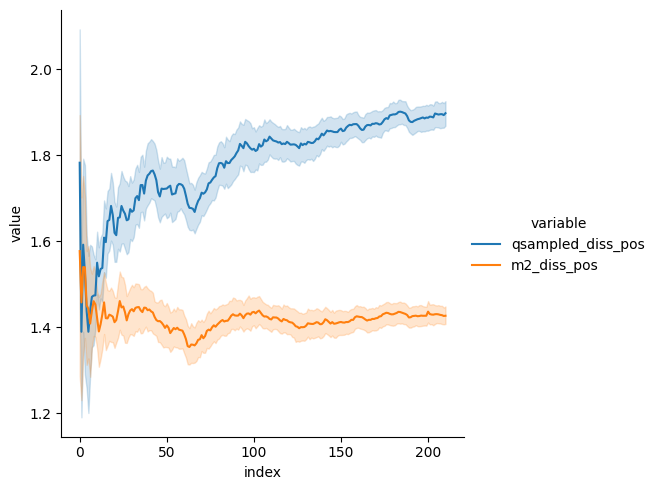

In [89]:
g = sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["qsampled_diss_pos", "m2_diss_pos"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

In [14]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [15]:
tikzplotlib_fix_ncols(g.figure)

In [ ]:
print(
    tpl.get_tikz_code(
        g.figure,
        standalone=False,
    )
)

In [9]:
def _sns_plot_to_df(ax, line_idx=0):
    # get mean
    mean_p_df = pd.DataFrame(
        data={0: ax.lines[line_idx].get_xdata(), 1: ax.lines[line_idx].get_ydata()}
    )

    # get upper/lower conf. bounds
    p = ax.collections[0].get_paths()
    p_df = pd.DataFrame(p[0].vertices).sort_values(by=[0, 1]).drop_duplicates()
    constant_bounds = p_df[~p_df[0].duplicated(keep=False)]
    p_df = pd.concat([p_df, constant_bounds]).sort_values(by=0)
    p_df["lim"] = [
        x
        for y in zip(np.tile("lower", len(mean_p_df)), np.tile("upper", len(mean_p_df)))
        for x in y
    ]

    # merge
    p_df_p = p_df.pivot(index=0, columns="lim").reset_index()
    p_df_p.columns = p_df_p.columns.to_flat_index()
    p_df_p = p_df_p.set_axis(["x", "ci_lower", "ci_upper"], axis="columns")
    df = pd.merge(p_df_p, mean_p_df, how="inner", left_on="x", right_on=0)

    df = df.rename(columns={1: "mean"}).drop(0, axis="columns")
    return df[["x", "mean", "ci_lower", "ci_upper"]]

<AxesSubplot:xlabel='x', ylabel='mean'>

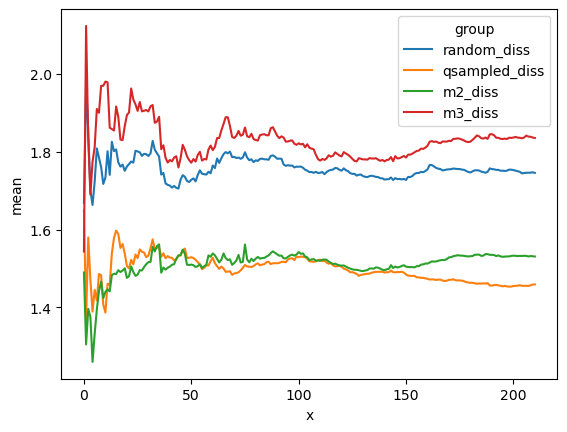

In [10]:
dpt = pd.concat(
    [
        _sns_plot_to_df(g.figure.gca(), i).assign(
            group=g.figure.gca().get_legend_handles_labels()[1][i]
        )
        for i in range(4)
    ]
)

sns.lineplot(data=dpt, x="x", y="mean", hue="group")

In [12]:
dpt.to_csv("data/ptsd/ptsd_disson_log.csv", index=False)

## Classification


Get dissonance values for specified number of runs, process for classifier training

### single run

In [127]:
def _get_quest_diss(diss_df, questions):
    qs_df = pd.DataFrame(
        [
            diss_df.groupby("run").nth(i)["qsampled_diss"].values
            for i in range(questions)
        ]
    ).T.assign(group="qsampled")
    m2_df = pd.DataFrame(
        [diss_df.groupby("run").nth(i)["m2_diss"].values for i in range(questions)]
    ).T.assign(group="m2")

    return pd.concat([qs_df, m2_df])


def _get_quest_diss_pos(diss_df, questions):
    qs_df = pd.DataFrame(
        [
            diss_df.groupby("run").nth(i)["qsampled_diss_pos"].values
            for i in range(questions)
        ]
    ).T.assign(group="qsampled")
    m2_df = pd.DataFrame(
        [diss_df.groupby("run").nth(i)["m2_diss_pos"].values for i in range(questions)]
    ).T.assign(group="m2")

    return pd.concat([qs_df, m2_df])

In [268]:
df_tra = pd.concat(
    [
        _compare_dissonance(
            samples,
            Tr.cognet_obj.qnet,
            Tr_pos.cognet_obj.qnet,
            plot=False,
        ).assign(run=i)
        for i in tqdm(range(20))
    ]
)

df_tst = pd.concat(
    [
        _compare_dissonance(
            samples,
            Tr.cognet_obj.qnet,
            Tr_pos.cognet_obj.qnet,
            plot=False,
        ).assign(run=i)
        for i in tqdm(range(5))
    ]
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [286]:
fig, ax = plt.subplots()

aucs = list()

quest_iter = range(1, 151, 5)

for i in tqdm(quest_iter):
    tra = _get_quest_diss(df_tra, i)
    tra_pos = _get_quest_diss_pos(df_tra, i)
    X_train = tra.iloc[:, :i]
    X_train_pos = tra_pos.iloc[:, :i].rename(columns=lambda x: str(x) + "_pos")
    X_train_all = pd.concat([X_train, X_train_pos], axis=1)
    X_train_all.columns = X_train_all.columns.astype(str)
    y_train = tra.iloc[:, -1]

    tst = _get_quest_diss(df_tst, i)
    tst_pos = _get_quest_diss_pos(df_tst, i)
    X_test = tst.iloc[:, :i]
    X_test_pos = tst_pos.iloc[:, :i].rename(columns=lambda x: str(x) + "_pos")
    X_test_all = pd.concat([X_test, X_test_pos], axis=1)
    X_test_all.columns = X_test_all.columns.astype(str)
    y_test = tst.iloc[:, -1]

    forest = RandomForestClassifier()
    forest.fit(
        X_train_all,
        y_train.replace(
            {
                "qsampled": 0,
                "m2": 1,
            }
        ),
    )

    r = RocCurveDisplay.from_estimator(
        forest,
        X_test_all,
        y_test.replace(
            {
                "qsampled": 0,
                "m2": 1,
            }
        ),
        pos_label=1,
        ax=ax,
        name=tra.columns[i - 1],
    )
    aucs.append(r.roc_auc)
    plt.close()

# ax.legend(bbox_to_anchor=(1.1, 1.05))

  0%|          | 0/30 [00:00<?, ?it/s]

<Axes: xlabel='questions asked'>

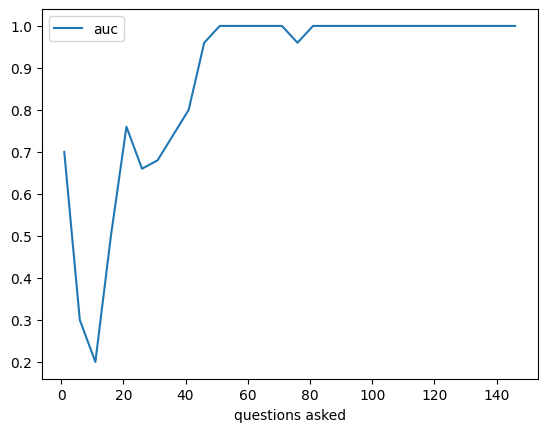

In [287]:
auc_df = pd.DataFrame({"questions asked": quest_iter, "auc": aucs})

auc_df.plot(x="questions asked", y="auc")

In [288]:
auc_df

,questions asked,auc
0,1,0.70
1,6,0.30
2,11,0.20
3,16,0.50
4,21,0.76
5,26,0.66
6,31,0.68
7,36,0.74
8,41,0.80
9,46,0.96


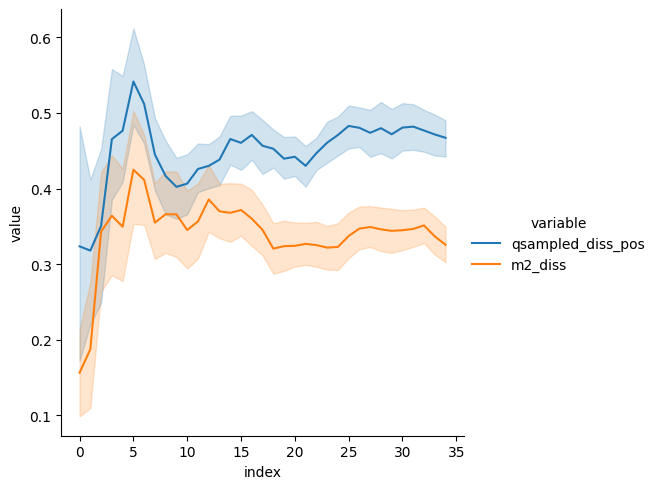

In [278]:
sns.relplot(
    data=pd.melt(
        df_tra[["qsampled_diss_pos", "m2_diss"]].reset_index(),
        id_vars="index",
    ).query("index < 35"),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

### batch run

In [3]:
def _get_quest_diss(diss_df, questions):
    qs_df = pd.DataFrame(
        [
            diss_df.groupby("run").nth(i)["qsampled_diss"].values
            for i in range(questions)
        ]
    ).T.assign(group="qsampled")
    m2_df = pd.DataFrame(
        [diss_df.groupby("run").nth(i)["m2_diss"].values for i in range(questions)]
    ).T.assign(group="m2")

    return pd.concat([qs_df, m2_df])


def _get_quest_diss_pos(diss_df, questions):
    qs_df = pd.DataFrame(
        [
            diss_df.groupby("run").nth(i)["qsampled_diss_pos"].values
            for i in range(questions)
        ]
    ).T.assign(group="qsampled")
    m2_df = pd.DataFrame(
        [diss_df.groupby("run").nth(i)["m2_diss_pos"].values for i in range(questions)]
    ).T.assign(group="m2")

    return pd.concat([qs_df, m2_df])

In [4]:
def _get_auc_df(n_train=20, n_test=5):
    Tr = truthnet()
    features, samples = Tr.load_data(
        datapath="data/ptsd/PTSD_cognet_test_processed.csv"
    )
    Tr.fit(modelpath="tmp_Qnet.joblib")
    Tr_pos = truthnet()
    feat_pos, samp_pos = Tr_pos.load_data(
        datapath="data/ptsd/PTSD_cognet_test_processed_pos_only.csv"
    )
    Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

    Ds = Tr.cognet_obj.qnet.predict_distributions(
        np.full_like(samples[0], fill_value="")
    )
    entrpy = list()
    for i in range(len(Ds)):
        entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))

    entropy_order = pd.Series(entrpy).sort_values().index

    fig, ax = plt.subplots()

    df_tra = pd.concat(
        [
            _compare_dissonance(
                samples,
                Tr.cognet_obj.qnet,
                Tr_pos.cognet_obj.qnet,
                order=entropy_order,
                diss_fcn=_diss_log,
                plot=False,
            ).assign(run=i)
            for i in tqdm(range(n_train))
        ]
    )

    df_tst = pd.concat(
        [
            _compare_dissonance(
                samples,
                Tr.cognet_obj.qnet,
                Tr_pos.cognet_obj.qnet,
                order=entropy_order,
                diss_fcn=_diss_log,
                plot=False,
            ).assign(run=i)
            for i in tqdm(range(n_test))
        ]
    )

    time = str(datetime.now())
    df_tra.to_csv("diss_log_training_" + time + ".csv", index=False)
    df_tst.to_csv("diss_log_test_" + time + ".csv", index=False)

    aucs = list()

    quest_iter = range(1, 211, 5)

    for i in quest_iter:
        tra = _get_quest_diss(df_tra, i)
        tra_pos = _get_quest_diss_pos(df_tra, i)
        X_train = tra.iloc[:, :i]
        X_train_pos = tra_pos.iloc[:, :i].rename(columns=lambda x: str(x) + "_pos")
        X_train_all = pd.concat([X_train, X_train_pos], axis=1)
        X_train_all.columns = X_train_all.columns.astype(str)
        y_train = tra.iloc[:, -1]

        tst = _get_quest_diss(df_tst, i)
        tst_pos = _get_quest_diss_pos(df_tst, i)
        X_test = tst.iloc[:, :i]
        X_test_pos = tst_pos.iloc[:, :i].rename(columns=lambda x: str(x) + "_pos")
        X_test_all = pd.concat([X_test, X_test_pos], axis=1)
        X_test_all.columns = X_test_all.columns.astype(str)
        y_test = tst.iloc[:, -1]

        forest = RandomForestClassifier()
        forest.fit(
            X_train_all,
            y_train.replace(
                {
                    "qsampled": 0,
                    "m2": 1,
                }
            ),
        )

        r = RocCurveDisplay.from_estimator(
            forest,
            X_test_all,
            y_test.replace(
                {
                    "qsampled": 0,
                    "m2": 1,
                }
            ),
            pos_label=1,
            ax=ax,
            name=tra.columns[i - 1],
        )
        aucs.append(r.roc_auc)
        plt.close()

    auc_df = pd.DataFrame({"questions asked": quest_iter, "auc": aucs})

    return auc_df

In [ ]:
for i in tqdm(range(10)):
    _get_auc_df(n_train=100, n_test=15).to_csv(
        "auc_df_log_train_samps_100_" + str(i) + ".csv", index=False
    )

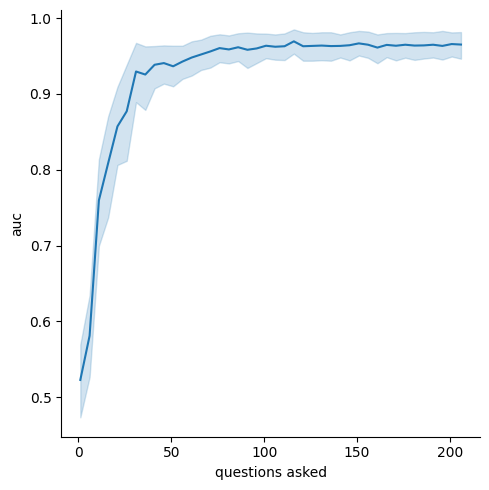

In [5]:
g = sns.relplot(
    data=pd.read_csv("data/classification/auc_df_x10_train_samps_100.csv"),
    x="questions asked",
    y="auc",
    kind="line",
)

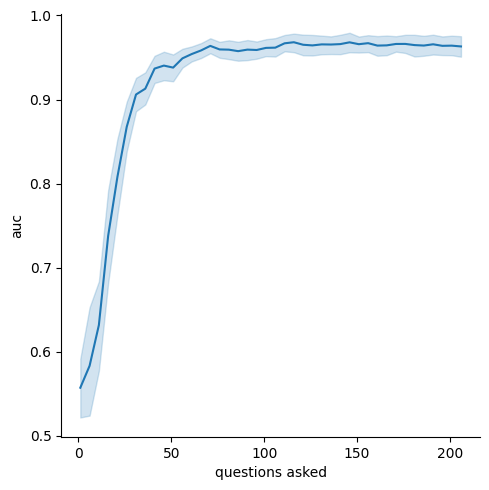

In [13]:
g = sns.relplot(
    data=pd.read_csv("data/classification/auc_df_x10_train_samps_200.csv"),
    x="questions asked",
    y="auc",
    kind="line",
)

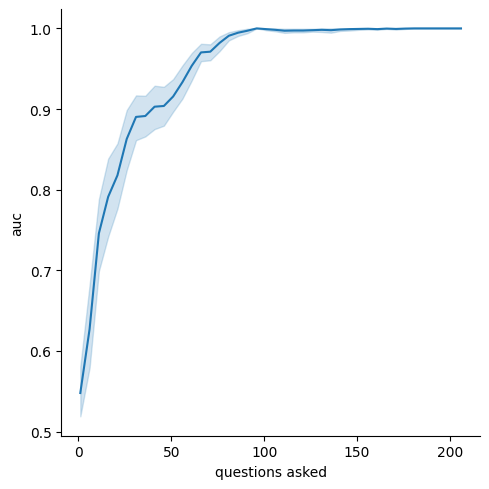

In [6]:
g = sns.relplot(
    data=pd.read_csv("data/classification/auc_df_x10_log_train_samps_100.csv"),
    x="questions asked",
    y="auc",
    kind="line",
)

In [ ]:
print(tpl.get_tikz_code(g.figure, standalone=False))

In [42]:
def _sns_plot_to_df(ax, line_idx=0):
    # get mean
    mean_p_df = pd.DataFrame(
        data={0: ax.lines[line_idx].get_xdata(), 1: ax.lines[0].get_ydata()}
    )

    # get upper/lower conf. bounds
    p = ax.collections[0].get_paths()
    p_df = pd.DataFrame(p[0].vertices).sort_values(by=[0, 1]).drop_duplicates()
    p_df["lim"] = [
        x
        for y in zip(np.tile("lower", len(mean_p_df)), np.tile("upper", len(mean_p_df)))
        for x in y
    ]

    # merge
    p_df_p = p_df.pivot(index=0, columns="lim").reset_index()
    p_df_p.columns = p_df_p.columns.to_flat_index()
    p_df_p = p_df_p.set_axis(["x", "ci_lower", "ci_upper"], axis="columns")
    df = pd.merge(p_df_p, mean_p_df, how="inner", left_on="x", right_on=0)

    df = df.rename(columns={1: "mean"}).drop(0, axis="columns")
    return df[["x", "mean", "ci_lower", "ci_upper"]]

## improving performance

In [22]:
def _get_group_diss(diss_df, questions, group):
    return pd.DataFrame(
        [diss_df.groupby("run").nth(i)[group].values for i in range(questions)]
    ).T.assign(group=group.replace("_pos", "").replace("_diss", ""))


def _merge_group_diss(diss_df, questions, group_vars, ratio=False):
    gs = [_get_group_diss(diss_df, questions, g) for g in group_vars]
    if ratio is True:
        gs_ratio = np.divide(gs[0], gs[1], where=gs[1].dtypes.ne(object)).combine_first(
            gs[1]
        )
        gs = gs + [gs_ratio]

    df = pd.concat(gs, axis=1).T.drop_duplicates().T

    df.insert(len(df.columns) - 1, "group", df.pop("group"))
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            str(dup) + "." + str(i) if i != 0 else str(dup)
            for i in range(sum(cols == dup))
        ]

    df.columns = cols
    return df


def _diss_train_df(diss_df, questions, groups, ratio=False):
    return pd.concat(
        [_merge_group_diss(diss_df, questions, g, ratio=ratio) for g in groups]
    )


def _auc_df_from_data(
    df_tra, df_tst, diss_vars, classifier, question_iterator, ratio=False
):
    aucs = list()

    fig, ax = plt.subplots()
    for i in question_iterator:
        tra = _diss_train_df(df_tra, i, diss_vars, ratio=ratio)
        X_train = tra.iloc[:, :i]
        y_train = tra.iloc[:, -1]

        tst = _diss_train_df(df_tst, i, diss_vars, ratio=ratio)
        X_test = tst.iloc[:, :i]
        y_test = tst.iloc[:, -1]

        classifier.fit(
            X_train.to_numpy(),
            y_train.replace(
                {
                    "qsampled": 0,
                    "m2": 1,
                }
            ),
        )

        r = RocCurveDisplay.from_estimator(
            classifier,
            X_test.to_numpy(),
            y_test.replace(
                {
                    "qsampled": 0,
                    "m2": 1,
                }
            ),
            pos_label=1,
            ax=ax,
            name=tra.columns[i - 1],
        )
        aucs.append(r.roc_auc)
        plt.close()

    auc_df = pd.DataFrame({"questions asked": quest_iter, "auc": aucs})
    return auc_df

  0%|          | 0/11 [00:00<?, ?it/s]

,x,mean,ci_lower,ci_upper
0,1.0,0.556364,0.531919,0.579601
1,6.0,0.624040,0.562611,0.690712
2,11.0,0.696970,0.613722,0.764247
3,16.0,0.738182,0.694929,0.778182
4,21.0,0.819798,0.788283,0.847273
5,26.0,0.831313,0.774545,0.884460


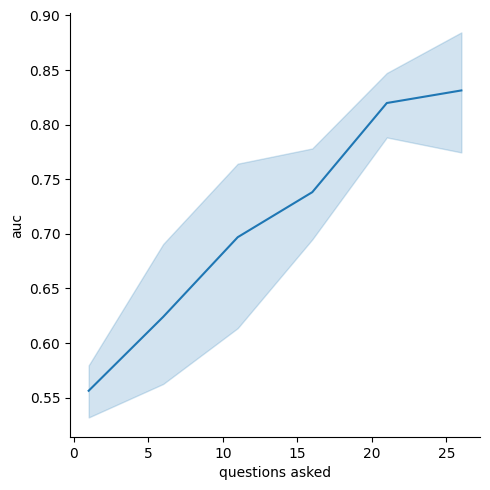

In [55]:
train_dfs = glob.glob("data/classification/train/100_samps_log/*.csv")
test_dfs = glob.glob("data/classification/test/100_samps_log/*.csv")

quest_iter = range(1, 31, 5)
diss_vars = [["qsampled_diss"], ["m2_diss"]]
classifier = RandomForestClassifier(n_estimators=100)

clf1 = LogisticRegression(max_iter=100)
clf2 = RandomForestClassifier(n_estimators=100)

classifier = xgb.XGBRFClassifier()
# classifier = lgb.LGBMClassifier()

tqdm._instances.clear()
auc_dfs = pd.concat(
    [
        _auc_df_from_data(
            pd.read_csv(train_dfs[i]),
            pd.read_csv(test_dfs[i]),
            diss_vars,
            classifier,
            quest_iter,
            ratio=False,
        )
        for i in tqdm(range(len(train_dfs)))
    ]
)

g = sns.relplot(
    data=auc_dfs,
    x="questions asked",
    y="auc",
    kind="line",
)

_sns_plot_to_df(g.figure.gca())

Merge all data, generate classifiers at specified question interval, process with zedstat:

In [6]:
train_dfs = glob.glob("data/classification/train/100_samps_log/*.csv")
test_dfs = glob.glob("data/classification/test/100_samps_log/*.csv")

df_tra = pd.concat(
    [
        pd.read_csv(train_dfs[i]).assign(run=lambda x: x["run"] + 100 * i)
        for i in range(len(train_dfs))
    ]
)

df_tst = pd.concat(
    [
        pd.read_csv(test_dfs[i]).assign(run=lambda x: x["run"] + 15 * i)
        for i in range(len(test_dfs))
    ]
)

,questions asked,auc,z_auc,z_auc_lb,z_auc_ub
0,1,0.556474,0.556474,0.556474,0.556474
1,6,0.642773,0.657842,0.582022,0.733758
2,11,0.746318,0.769330,0.707455,0.831253
3,16,0.793095,0.809997,0.748848,0.871183
4,21,0.823361,0.839848,0.785553,0.894160
5,26,0.852599,0.863364,0.809917,0.916827


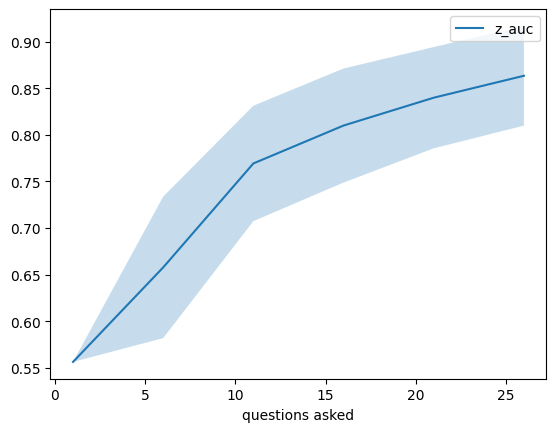

In [54]:
fig, ax = plt.subplots()
quest_iter = range(1, 31, 5)
diss_vars = [["qsampled_diss", "qsampled_diss_pos"], ["m2_diss", "m2_diss_pos"]]

aucs = list()
z_aucs = list()
z_aucs_lb = list()
z_aucs_ub = list()
roc_dfs = list()
classifier = RandomForestClassifier(n_estimators=100)
classifier = lgb.LGBMClassifier()
classifier = xgb.XGBRFClassifier()

for i in quest_iter:
    tra = _diss_train_df(df_tra, i, diss_vars, ratio=False)
    X_train = tra.iloc[:, :i]
    y_train = tra.iloc[:, -1]

    tst = _diss_train_df(df_tst, i, diss_vars, ratio=False)
    X_test = tst.iloc[:, :i]
    y_test = tst.iloc[:, -1]

    classifier.fit(
        X_train.to_numpy(),
        y_train.replace(
            {
                "qsampled": 0,
                "m2": 1,
            }
        ),
    )

    r = RocCurveDisplay.from_estimator(
        classifier,
        X_test.to_numpy(),
        y_test.replace(
            {
                "qsampled": 0,
                "m2": 1,
            }
        ),
        pos_label=1,
        ax=ax,
        name=tra.columns[i - 1],
    )
    aucs.append(r.roc_auc)
    fpr, tpr, thresholds = roc_curve(
        y_test.replace(
            {
                "qsampled": 0,
                "m2": 1,
            }
        ),
        classifier.predict_proba(X_test.to_numpy())[:, 1],
        pos_label=1,
    )
    roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
    roc_dfs.append(roc_df)
    plt.close()

    try:
        zt = zedstat.processRoc(
            roc_df,
            order=3,
            total_samples=1000,
            positive_samples=150,
            alpha=0.01,
            prevalence=0.15,
        )

        zt.smooth(STEP=0.01)
        zt.allmeasures(interpolate=False)
        zt.usample(precision=3)
        zt.getBounds()
        z_aucs.append(zt.auc()[0])
        z_aucs_lb.append(zt.auc()[2])
        z_aucs_ub.append(zt.auc()[1])
    except:
        z_aucs.append(r.roc_auc)
        z_aucs_lb.append(r.roc_auc)
        z_aucs_ub.append(r.roc_auc)

auc_df = pd.DataFrame(
    {
        "questions asked": quest_iter,
        "auc": aucs,
        "z_auc": z_aucs,
        "z_auc_lb": z_aucs_lb,
        "z_auc_ub": z_aucs_ub,
    }
)

ax = auc_df.plot(x="questions asked", y="z_auc")
ax.fill_between(
    auc_df["questions asked"], auc_df["z_auc_ub"], auc_df["z_auc_lb"], alpha=0.25
)

auc_df

In [4]:
diss_vars = [["qsampled_diss", "qsampled_diss_pos"], ["m2_diss", "m2_diss_pos"]]

In [21]:
_merge_group_diss(df_tra, 5, ["qsampled_diss", "qsampled_diss_pos"], ratio=True)

,0,1,2,3,4,0.1,1.1,2.1,3.1,4.1,0.2,1.2,2.2,3.2,4.2,group
0,0.148683,1.690402,1.224294,1.472669,1.189577,0.27996,2.844909,1.664482,1.624325,1.243832,0.531087,0.594185,0.73554,0.906634,0.956381,qsampled
1,0.148683,0.158317,0.727838,1.713331,1.382124,0.27996,0.290558,0.67991,0.838687,0.657552,0.531087,0.544874,1.070492,2.042873,2.101924,qsampled
2,0.148683,0.158317,0.202904,0.072268,0.069256,0.27996,0.290558,0.355057,0.24496,0.18257,0.531087,0.544874,0.571469,0.295018,0.379341,qsampled
3,0.148683,0.158317,0.202904,0.072268,0.069256,0.27996,0.290558,0.355057,0.24496,0.18257,0.531087,0.544874,0.571469,0.295018,0.379341,qsampled
4,0.148683,0.158317,1.087025,0.330529,0.99283,0.27996,0.290558,1.029851,1.051637,1.022335,0.531087,0.544874,1.055516,0.3143,0.971139,qsampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.148683,0.158317,0.202904,0.086066,0.079351,0.27996,0.290558,0.355057,0.24496,0.18257,0.531087,0.544874,0.571469,0.351345,0.43463,qsampled
1096,0.148683,0.158317,0.202904,0.893711,1.333177,0.27996,0.290558,0.355057,0.795592,0.797866,0.531087,0.544874,0.571469,1.123328,1.670928,qsampled
1097,0.148683,1.303807,0.966564,0.516757,0.423904,0.27996,1.301699,1.029151,0.318175,0.221884,0.531087,1.001619,0.939185,1.624131,1.910479,qsampled
1098,0.148683,0.158317,0.202904,0.893711,1.333177,0.27996,0.290558,0.355057,0.795592,0.797866,0.531087,0.544874,0.571469,1.123328,1.670928,qsampled


In [15]:
gs = [_get_group_diss(df_tra, 5, g) for g in ["qsampled_diss", "qsampled_diss_pos"]]

In [18]:
np.divide(gs[0], gs[1], where=gs[1].dtypes.ne(object)).combine_first(gs[1])

,0,1,2,3,4,group
0,0.531087,0.594185,0.73554,0.906634,0.956381,qsampled
1,0.531087,0.544874,1.070492,2.042873,2.101924,qsampled
2,0.531087,0.544874,0.571469,0.295018,0.379341,qsampled
3,0.531087,0.544874,0.571469,0.295018,0.379341,qsampled
4,0.531087,0.544874,1.055516,0.3143,0.971139,qsampled
...,...,...,...,...,...,...
1095,0.531087,0.544874,0.571469,0.351345,0.43463,qsampled
1096,0.531087,0.544874,0.571469,1.123328,1.670928,qsampled
1097,0.531087,1.001619,0.939185,1.624131,1.910479,qsampled
1098,0.531087,0.544874,0.571469,1.123328,1.670928,qsampled


In [19]:
gs[0]

,0,1,2,3,4,group
0,0.148683,1.690402,1.224294,1.472669,1.189577,qsampled
1,0.148683,0.158317,0.727838,1.713331,1.382124,qsampled
2,0.148683,0.158317,0.202904,0.072268,0.069256,qsampled
3,0.148683,0.158317,0.202904,0.072268,0.069256,qsampled
4,0.148683,0.158317,1.087025,0.330529,0.992830,qsampled
...,...,...,...,...,...,...
1095,0.148683,0.158317,0.202904,0.086066,0.079351,qsampled
1096,0.148683,0.158317,0.202904,0.893711,1.333177,qsampled
1097,0.148683,1.303807,0.966564,0.516757,0.423904,qsampled
1098,0.148683,0.158317,0.202904,0.893711,1.333177,qsampled


## Def. of dissonance

Letting $\text{ans}$ be the set of answers and a response $x \in \text{ans}$, the (linear) dissonance of $x$ is defined as $$\operatorname{Dissonance}(x)= 1 - \dfrac{\operatorname{Pr}(x)}{\operatorname{max}_{a \in \text{ans}}\operatorname{Pr}(a)}$$ 

Thus the dissonance is supported on $[0,1]$, is minimized at the highest probability response, and is maximal ($=1$) at probability $0$ responses. We also see that it scales linearly with probability of the response.

## Results

- distinguish between random/non-random responses
- reconstruction of responses
- include diagnostic phenotypes